Proyek Klasifikasi Gambar: Brain Stroke CT-Scan dataset
- Nama: Ladya Kusuma
- Email: *mc295d5x2480@student.devacademy.id*
- ID Dicoding: *mc295d5x2480*

# Import Semua Packages/Library yang Digunakan

In [3]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt

In [4]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [5]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #menonaktifkan warning yang mungkin muncul, seperti warning FutureWarning

# Data Preparation

## Data Loading

In [7]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"willkusuma","key":"114f926728e38ef1e4cb2006ef0ddc79"}'}

In [8]:
#Pindahkan file kaggle.json ke folder .kaggle
!mkdir -p ~/.kaggle
!cp kaggle\ \(1\).json ~/.kaggle/kaggle.json

In [9]:
#Ubah permission file agar tidak terbaca publik
!chmod 600 ~/.kaggle/kaggle.json


In [10]:
#Download dataset-nya
!kaggle datasets download -d ozguraslank/brain-stroke-ct-dataset

Dataset URL: https://www.kaggle.com/datasets/ozguraslank/brain-stroke-ct-dataset
License(s): other


In [12]:
# Unzip file-nya
!unzip brain-stroke-ct-dataset.zip


Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Brain_Stroke_CT_Dataset/Normal/DICOM/16125.dcm  
  inflating: Brain_Stroke_CT_Dataset/Normal/DICOM/16127.dcm  
  inflating: Brain_Stroke_CT_Dataset/Normal/DICOM/16128.dcm  
  inflating: Brain_Stroke_CT_Dataset/Normal/DICOM/16129.dcm  
  inflating: Brain_Stroke_CT_Dataset/Normal/DICOM/16130.dcm  
  inflating: Brain_Stroke_CT_Dataset/Normal/DICOM/16132.dcm  
  inflating: Brain_Stroke_CT_Dataset/Normal/DICOM/16134.dcm  
  inflating: Brain_Stroke_CT_Dataset/Normal/DICOM/16135.dcm  
  inflating: Brain_Stroke_CT_Dataset/Normal/DICOM/16136.dcm  
  inflating: Brain_Stroke_CT_Dataset/Normal/DICOM/16138.dcm  
  inflating: Brain_Stroke_CT_Dataset/Normal/DICOM/16141.dcm  
  inflating: Brain_Stroke_CT_Dataset/Normal/DICOM/16144.dcm  
  inflating: Brain_Stroke_CT_Dataset/Normal/DICOM/16145.dcm  
  inflating: Brain_Stroke_CT_Dataset/Normal/DICOM/16147.dcm  
  inflating: Brain_Stroke_CT_Dataset/Normal/DICOM/16148.dcm  
  inflating

# Data Pre prosessing

## Split Data

In [13]:
import os
import random
import shutil
from sklearn.model_selection import train_test_split

# Path awal
data_dir = "Brain_Stroke_CT_Dataset"
output_dir = os.path.join(data_dir, "dataset_split")

# Label/kelas
classes = ["Bleeding", "Ischemia", "Normal"]

# Persentase split
train_pct = 0.7
val_pct = 0.2
test_pct = 0.1

for cls in classes:
    img_dir = os.path.join(data_dir, cls, "PNG")
    images = os.listdir(img_dir)

    # Shuffle dan split
    train_imgs, temp_imgs = train_test_split(images, test_size=(1-train_pct), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=(test_pct/(test_pct + val_pct)), random_state=42)

    for split, split_imgs in zip(["train", "val", "test"], [train_imgs, val_imgs, test_imgs]):
        split_dir = os.path.join(output_dir, split, cls)
        os.makedirs(split_dir, exist_ok=True)

        for img in split_imgs:
            src = os.path.join(img_dir, img)
            dst = os.path.join(split_dir, img)
            shutil.copy2(src, dst)

print("Splitting data selesai.")

Splitting data selesai.


In [23]:
# Data Preprocessing dengan ImageDataGenerator

# Ukuran gambar target yang diinginkan
img_height, img_width = 128, 128
batch_size = 64

# Path ke direktori hasil split sebelumnya
base_dir = "Brain_Stroke_CT_Dataset/dataset_split"

# Data Augmentation untuk training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=25,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    shear_range=0.2,
    fill_mode='nearest'
)


val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'val'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 4653 images belonging to 3 classes.
Found 1330 images belonging to 3 classes.
Found 667 images belonging to 3 classes.


In [24]:
import os

base_path = "Brain_Stroke_CT_Dataset/dataset_split"
splits = ["train", "val", "test"]
classes = ["Bleeding", "Ischemia"]

for split in splits:
    print(f"lihat jumlah masing2 Split: {split}")
    for cls in classes:
        class_path = os.path.join(base_path, split, cls)
        num_images = len(os.listdir(class_path))
        print(f"  - {cls}: {num_images} gambar")


lihat jumlah masing2 Split: train
  - Bleeding: 765 gambar
  - Ischemia: 790 gambar
lihat jumlah masing2 Split: val
  - Bleeding: 218 gambar
  - Ischemia: 226 gambar
lihat jumlah masing2 Split: test
  - Bleeding: 110 gambar
  - Ischemia: 114 gambar


In [16]:
print(train_generator.class_indices)


{'Bleeding': 0, 'Ischemia': 1, 'Normal': 2}


# Modeling

In [31]:
model = Sequential([
    # 1st Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)), # Changed input shape to (128, 128, 3)
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(momentum=0.99), #buat normalisasi

    # 2nd Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(momentum=0.99),

    # 3nd Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(momentum=0.99),

    # 4nd Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(momentum=0.99),

    GlobalAveragePooling2D(), # "meringkas" fitur penting saja dari tiap channel, bukan semua detailnya
    Dropout(0.25),  # atasi overfitting

    Dense(128, activation='relu' , kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dense(3, activation='softmax')
])

In [26]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True)


In [28]:
epochs = 70

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    batch_size=64,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.5772 - loss: 1.0047

73/73 ━━━━━━━━━━━━━━━━━━━━ 54s 647ms/step - accuracy: 0.5781 - loss: 1.0036 - val_accuracy: 0.6662 - val_loss: 0.9906
Epoch 2/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 556ms/step - accuracy: 0.6807 - loss: 0.8547 - val_accuracy: 0.6662 - val_loss: 1.4473
Epoch 3/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 560ms/step - accuracy: 0.7166 - loss: 0.7925 - val_accuracy: 0.6662 - val_loss: 3.2284
Epoch 4/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 536ms/step - accuracy: 0.7446 - loss: 0.7190 - val_accuracy: 0.6662 - val_loss: 3.1213
Epoch 5/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 535ms/step - accuracy: 0.7623 - loss: 0.6575 - val_accuracy: 0.6662 - val_loss: 3.8703
Epoch 6/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 535ms/step - accuracy: 0.7689 - loss: 0.6359 - val_accuracy: 0.6662 - val_loss: 3.0831
Epoch 7/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 535ms/step - accuracy: 0.7906 - loss: 0.5815 - val_accuracy: 0.6662 - val_loss: 2.2717
Epoch 8/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 40s 550ms/step - accuracy: 0.8003 - loss: 0.5587 - val_accuracy: 0.666

73/73 ━━━━━━━━━━━━━━━━━━━━ 40s 549ms/step - accuracy: 0.8142 - loss: 0.5333 - val_accuracy: 0.6820 - val_loss: 1.0325
Epoch 10/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 40s 543ms/step - accuracy: 0.8381 - loss: 0.4852 - val_accuracy: 0.6737 - val_loss: 1.6760
Epoch 11/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.8366 - loss: 0.4651

73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 541ms/step - accuracy: 0.8366 - loss: 0.4651 - val_accuracy: 0.7812 - val_loss: 0.6504
Epoch 12/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 40s 542ms/step - accuracy: 0.8414 - loss: 0.4484 - val_accuracy: 0.7692 - val_loss: 0.6512
Epoch 13/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 40s 535ms/step - accuracy: 0.8326 - loss: 0.4515 - val_accuracy: 0.7602 - val_loss: 0.7301
Epoch 14/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 533ms/step - accuracy: 0.8528 - loss: 0.4172 - val_accuracy: 0.7421 - val_loss: 0.8210
Epoch 15/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.8643 - loss: 0.4149

73/73 ━━━━━━━━━━━━━━━━━━━━ 40s 542ms/step - accuracy: 0.8642 - loss: 0.4149 - val_accuracy: 0.8203 - val_loss: 0.5063
Epoch 16/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 536ms/step - accuracy: 0.8763 - loss: 0.3785 - val_accuracy: 0.7699 - val_loss: 0.7182
Epoch 17/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 535ms/step - accuracy: 0.8689 - loss: 0.3858 - val_accuracy: 0.7338 - val_loss: 0.8710
Epoch 18/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 529ms/step - accuracy: 0.8737 - loss: 0.3749 - val_accuracy: 0.7947 - val_loss: 0.6158
Epoch 19/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 533ms/step - accuracy: 0.8879 - loss: 0.3539 - val_accuracy: 0.7120 - val_loss: 0.7037
Epoch 20/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 537ms/step - accuracy: 0.8725 - loss: 0.3773 - val_accuracy: 0.6932 - val_loss: 1.5407
Epoch 21/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.8816 - loss: 0.3588

73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 529ms/step - accuracy: 0.8816 - loss: 0.3588 - val_accuracy: 0.8346 - val_loss: 0.4919
Epoch 22/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 532ms/step - accuracy: 0.8870 - loss: 0.3495 - val_accuracy: 0.7797 - val_loss: 0.7905
Epoch 23/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 527ms/step - accuracy: 0.8853 - loss: 0.3309 - val_accuracy: 0.7992 - val_loss: 0.6538
Epoch 24/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 531ms/step - accuracy: 0.8800 - loss: 0.3586 - val_accuracy: 0.7662 - val_loss: 0.8418
Epoch 25/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 531ms/step - accuracy: 0.9000 - loss: 0.3148 - val_accuracy: 0.8083 - val_loss: 0.5277
Epoch 26/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 38s 528ms/step - accuracy: 0.9048 - loss: 0.2952 - val_accuracy: 0.7602 - val_loss: 0.8103
Epoch 27/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8924 - loss: 0.3169

73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 528ms/step - accuracy: 0.8924 - loss: 0.3169 - val_accuracy: 0.8789 - val_loss: 0.3572
Epoch 28/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 532ms/step - accuracy: 0.8937 - loss: 0.3023 - val_accuracy: 0.7985 - val_loss: 0.7151
Epoch 29/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 533ms/step - accuracy: 0.9012 - loss: 0.2966 - val_accuracy: 0.8233 - val_loss: 0.5965
Epoch 30/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 529ms/step - accuracy: 0.8923 - loss: 0.3263 - val_accuracy: 0.8744 - val_loss: 0.3747
Epoch 31/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 531ms/step - accuracy: 0.9053 - loss: 0.2829 - val_accuracy: 0.8504 - val_loss: 0.4537
Epoch 32/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 38s 525ms/step - accuracy: 0.9106 - loss: 0.2723 - val_accuracy: 0.8256 - val_loss: 0.5295
Epoch 33/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 528ms/step - accuracy: 0.9033 - loss: 0.2908 - val_accuracy: 0.7241 - val_loss: 1.2138
Epoch 34/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 38s 523ms/step - accuracy: 0.9152 - loss: 0.2585 - val_accuracy

# Evaluasi dan Visualisai

In [29]:
loss, accuracy = model.evaluate(test_generator)
print(f"Akurasi Test: {accuracy*100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 278ms/step - accuracy: 0.8717 - loss: 0.3663
Akurasi Test: 90.85%


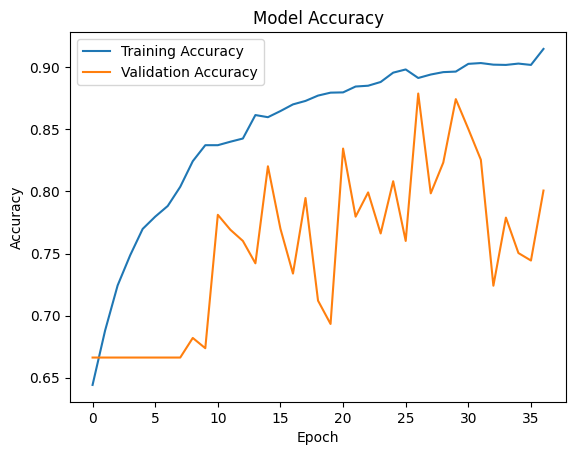

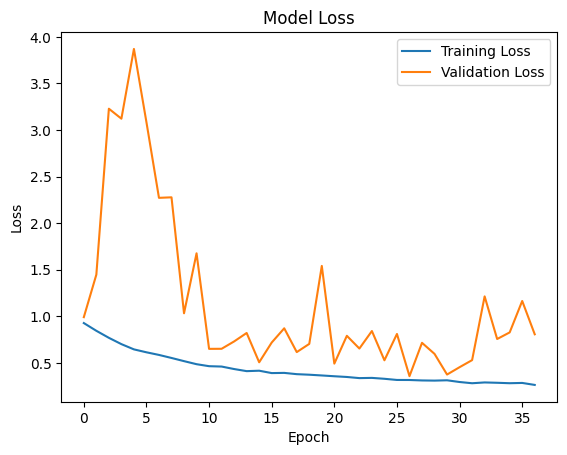

In [30]:
# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Konversi Model

In [44]:
# Simpan model ke format SavedModel (folder)
model.save('stroke_model.h5')

In [39]:
# Load model dari SavedModel
loaded_model = tf.keras.models.load_model('stroke_model.h5')

# Konversi ke dalam formatTFLite
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Simpan ke file
with open('stroke_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp_c2ofvtc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138491945835344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138491945842832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138491945844368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138491945842256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138491945844176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138491945843024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138491945841872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138491945840528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138491945839568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138491945842448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1384919458397

In [42]:
# Menyimpan Model ke Dalam Format TFJS
!pip install tensorflowjs

# Export ke format TFJS
!tensorflowjs_converter \
    --input_format=keras \
    stroke_model.h5 \
    tfjs_model


2025-04-25 13:35:31.897878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745588131.917017   23288 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745588131.922961   23288 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


# Inference (Optional)